In [ ]:
!wget https://www.dropbox.com/scl/fi/dwwd3r0gvxaiuq6pjnb9v/NF-ToN-IoT-V2.parquet?rlkey=kwfzpx81rpmahd61r9zkx2ct3&st=lfyqbgbt&dl=0 -O NF-ToN-IoT-V2.parquet

/bin/bash: line 1: -O: command not found
--2025-11-15 07:39:04--  https://www.dropbox.com/scl/fi/dwwd3r0gvxaiuq6pjnb9v/NF-ToN-IoT-V2.parquet?rlkey=kwfzpx81rpmahd61r9zkx2ct3
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucccad594f4cb7860055239560be.dl.dropboxusercontent.com/cd/0/inline/C1MsHCU9BgnvmMNqRewUIXYp3YuwpjyXAJT4AFsufXrGGuLE_Xvv57sFd7AAE2J3caHxDiy1lD9XLqKipXpKYhElv23LbTthXDe26VFKQpodz9P6v29TXzpaGNZFh8CWTlnpTeoU0qc12L2gdQL-Kc_y/file# [following]
--2025-11-15 07:39:05--  https://ucccad594f4cb7860055239560be.dl.dropboxusercontent.com/cd/0/inline/C1MsHCU9BgnvmMNqRewUIXYp3YuwpjyXAJT4AFsufXrGGuLE_Xvv57sFd7AAE2J3caHxDiy1lD9XLqKipXpKYhElv23LbTthXDe26VFKQpodz9P6v29TXzpaGNZFh8CWTlnpTeoU0qc12L2gdQL-Kc_y/file
Resolving ucccad594f4cb7860055239560be.dl.dropboxusercontent.com (ucccad594f4cb7860055239560

In [ ]:
!pip install --quiet pennylane torch scikit-learn pandas numpy pyarrow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 76.2 MB/s eta 0:00:00


In [ ]:
# Cell 1: imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy



/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
# Cell 2: load parquet file (update path if needed)
# Put your NF-ToN-IoT-v2.parquet in Colab /content or mount Drive and use path.
parquet_path = "/content/NF-ToN-IoT-V2.parquet?rlkey=kwfzpx81rpmahd61r9zkx2ct3"  # <- update if needed
df = pd.read_parquet(parquet_path)

# Quick peek
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head().T  # show transpose for readability


Rows: 13135881
Columns: ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack']


,0,1,2,3,4
L4_SRC_PORT,49235,49228,0,65317,60766
L4_DST_PORT,4444,1880,0,1900,15600
PROTOCOL,6,6,1,17,17
L7_PROTO,0.0,0.0,0.0,0.0,0.0
IN_BYTES,155392,1600,212,165,63
IN_PKTS,202,40,2,1,1
OUT_BYTES,34552,35741,0,0,0
OUT_PKTS,149,65,0,0,0
TCP_FLAGS,24,24,0,0,0
CLIENT_TCP_FLAGS,24,16,0,0,0


In [ ]:

# Sample for Colab Free Tier
sample_n = 100000
df_sample = df.sample(n=sample_n, random_state=42) if len(df) > sample_n else df.copy()

# Features and labels
drop_cols = ["Attack"]
if "Label" in df_sample.columns:
    drop_cols.append("Label")
X = df_sample.drop(columns=drop_cols).select_dtypes(include=[np.number]).fillna(0.0).values
y = df_sample["Attack"].astype("category").cat.codes.values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 4 components → 4 qubits
pca = PCA(n_components=4, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Split train for 2 clients
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(
    X_train, y_train, test_size=0.5, random_state=1, stratify=y_train
)


In [ ]:
batch_size = 16

def get_loader(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader_0 = get_loader(X_train_0, y_train_0)
train_loader_1 = get_loader(X_train_1, y_train_1)
test_loader = get_loader(X_test, y_test)


In [ ]:
n_qubits = 4
n_layers_var = 1
num_classes = len(np.unique(y))

dev = qml.device("default.qubit", wires=n_qubits)

def variational(weights):
    for layer in range(n_layers_var):
        for q in range(n_qubits):
            qml.Rot(weights[layer, q, 0], weights[layer, q, 1], weights[layer, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    variational(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers_var, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)


In [ ]:
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qlayer
        self.fc1 = nn.Linear(n_qubits, 4)
        self.fc2 = nn.Linear(4, num_classes)

    def forward(self, x):
        x = self.qnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

global_model = HybridQNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model.to(device)


HybridQNN(
  (qnn): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=10, bias=True)
)

In [ ]:
def get_weights(model):
    return deepcopy({k: v.cpu() for k, v in model.state_dict().items()})

def set_weights(model, weights):
    model.load_state_dict(deepcopy(weights))

def local_train(model, train_loader, epochs=3, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    return get_weights(model)

def average_weights(weights_list):
    avg = deepcopy(weights_list[0])
    for k in avg.keys():
        for w in weights_list[1:]:
            avg[k] += w[k]
        avg[k] = avg[k] / len(weights_list)
    return avg


In [ ]:
num_rounds = 3
local_epochs = 3

clients_loaders = [train_loader_0, train_loader_1]
global_weights = get_weights(global_model)

for r in range(1, num_rounds+1):
    print(f"\n--- Federated Round {r} ---")
    client_weights = []
    for cid, loader in enumerate(clients_loaders):
        client_model = HybridQNN().to(device)
        set_weights(client_model, global_weights)
        w = local_train(client_model, loader, epochs=local_epochs)
        client_weights.append(w)
        print(f" Client {cid} done")
    global_weights = average_weights(client_weights)
    set_weights(global_model, global_weights)

    # Evaluate on test
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = global_model(X_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    print(f"After Round {r} -> Test Accuracy: {acc:.4f}")



--- Federated Round 1 ---


ValueError: Features must be of length 4 or less; got length 14.

In [ ]:
# Cell: PCA to retain 95% variance
from sklearn.decomposition import PCA

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to retain 95% variance
pca = PCA(n_components=0.8, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Number of qubits = number of PCA components
n_qubits = X_pca.shape[1]
print(f"PCA retained {n_qubits} components to cover 80% variance")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Split train for 2 clients
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(
    X_train, y_train, test_size=0.5, random_state=1, stratify=y_train
)


PCA retained 14 components to cover 80% variance


In [ ]:


# Sample for Colab Free Tier
sample_n = 50000
df_sample = df.sample(n=sample_n, random_state=42) if len(df) > sample_n else df.copy()

# Features and labels
drop_cols = ["Attack"]
if "Label" in df_sample.columns:
    drop_cols.append("Label")
X = df_sample.drop(columns=drop_cols).select_dtypes(include=[np.number]).fillna(0.0).values
y = df_sample["Attack"].astype("category").cat.codes.values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to top 10 components
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

n_qubits = min(X_pca.shape[1], 10)
X_pca = X_pca[:, :n_qubits]
print(f"Using {n_qubits} qubits for QNN (top PCA components)")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Split train for 2 clients
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(
    X_train, y_train, test_size=0.5, random_state=1, stratify=y_train
)


Using 10 qubits for QNN (top PCA components)


In [ ]:
batch_size = 16

def get_loader(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader_0 = get_loader(X_train_0, y_train_0)
train_loader_1 = get_loader(X_train_1, y_train_1)
test_loader = get_loader(X_test, y_test)


In [ ]:
n_layers_var = 1
num_classes = len(np.unique(y))

dev = qml.device("default.qubit", wires=n_qubits)

def variational(weights):
    for layer in range(n_layers_var):
        for q in range(n_qubits):
            qml.Rot(weights[layer, q, 0], weights[layer, q, 1], weights[layer, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1) % n_qubits])

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    variational(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers_var, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)


In [ ]:
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qlayer
        self.fc1 = nn.Linear(n_qubits, 4)
        self.fc2 = nn.Linear(4, num_classes)

    def forward(self, x):
        x = self.qnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

global_model = HybridQNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model.to(device)


HybridQNN(
  (qnn): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=10, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=10, bias=True)
)

In [ ]:
def get_weights(model):
    return deepcopy({k: v.cpu() for k, v in model.state_dict().items()})

def set_weights(model, weights):
    model.load_state_dict(deepcopy(weights))

def local_train(model, train_loader, epochs=3, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    return get_weights(model)

def average_weights(weights_list):
    avg = deepcopy(weights_list[0])
    for k in avg.keys():
        for w in weights_list[1:]:
            avg[k] += w[k]
        avg[k] = avg[k] / len(weights_list)
    return avg


In [ ]:
num_rounds = 3
local_epochs = 3

clients_loaders = [train_loader_0, train_loader_1]
global_weights = get_weights(global_model)

for r in range(1, num_rounds+1):
    print(f"\n--- Federated Round {r} ---")
    client_weights = []
    for cid, loader in enumerate(clients_loaders):
        client_model = HybridQNN().to(device)
        set_weights(client_model, global_weights)
        w = local_train(client_model, loader, epochs=local_epochs)
        client_weights.append(w)
        print(f" Client {cid} done")
    global_weights = average_weights(client_weights)
    set_weights(global_model, global_weights)

    # Evaluate on test
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = global_model(X_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    print(f"After Round {r} -> Test Accuracy: {acc:.4f}")



--- Federated Round 1 ---
 Client 0 done
 Client 1 done
After Round 1 -> Test Accuracy: 0.4170

--- Federated Round 2 ---
 Client 0 done
 Client 1 done
After Round 2 -> Test Accuracy: 0.6100

--- Federated Round 3 ---
 Client 0 done
 Client 1 done
After Round 3 -> Test Accuracy: 0.6040


In [ ]:
def clip_weights(weights, clip_value=1.0):
    clipped = deepcopy(weights)
    for k in clipped.keys():
        clipped[k] = torch.clamp(clipped[k], -clip_value, clip_value)
    return clipped

def add_noise(weights, sigma=0.1):
    noisy = deepcopy(weights)
    for k in noisy.keys():
        noise = torch.normal(0, sigma, size=noisy[k].shape)
        noisy[k] += noise
    return noisy


In [ ]:
num_rounds = 3
local_epochs = 3
clip_value = 1.0
sigma = 0.05  # adjust for stronger/weaker DP

clients_loaders = [train_loader_0, train_loader_1]
global_weights = get_weights(global_model)

for r in range(1, num_rounds+1):
    print(f"\n--- Federated Round {r} (with DP) ---")
    client_weights = []
    for cid, loader in enumerate(clients_loaders):
        client_model = HybridQNN().to(device)
        set_weights(client_model, global_weights)
        w = local_train(client_model, loader, epochs=local_epochs)
        w = clip_weights(w, clip_value=clip_value)
        w = add_noise(w, sigma=sigma)
        client_weights.append(w)
        print(f" Client {cid} done with DP")

    global_weights = average_weights(client_weights)
    set_weights(global_model, global_weights)

    # Evaluate on test
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = global_model(X_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    print(f"After Round {r} -> Test Accuracy: {acc:.4f}")



--- Federated Round 1 (with DP) ---


KeyboardInterrupt: 

In [ ]:
# PCA to retain 95% variance (19 components)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

n_qubits = X_pca.shape[1]  # 19 qubits
print(f"PCA retained {n_qubits} components → {2**n_qubits} amplitudes in quantum state")


PCA retained 23 components → 8388608 amplitudes in quantum state


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Split for 2 clients
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(
    X_train, y_train, test_size=0.5, random_state=1, stratify=y_train
)

# DataLoaders
train_loader_0 = get_loader(X_train_0, y_train_0)
train_loader_1 = get_loader(X_train_1, y_train_1)
test_loader = get_loader(X_test, y_test)


In [ ]:
n_layers_var = 1
dev = qml.device("default.qubit", wires=n_qubits)

def variational(weights):
    for layer in range(n_layers_var):
        for q in range(n_qubits):
            qml.Rot(weights[layer, q, 0], weights[layer, q, 1], weights[layer, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1) % n_qubits])

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    variational(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers_var, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)


In [ ]:
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qlayer
        self.fc1 = nn.Linear(n_qubits, 4)
        self.fc2 = nn.Linear(4, num_classes)

    def forward(self, x):
        x = self.qnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

global_model = HybridQNN().to(device)


In [ ]:
num_rounds = 3
local_epochs = 3
clients_loaders = [train_loader_0, train_loader_1]

global_weights = get_weights(global_model)

for r in range(1, num_rounds+1):
    print(f"\n--- Federated Round {r} ---")
    client_weights = []
    for cid, loader in enumerate(clients_loaders):
        client_model = HybridQNN().to(device)
        set_weights(client_model, global_weights)
        w = local_train(client_model, loader, epochs=local_epochs)
        client_weights.append(w)
        print(f" Client {cid} done")

    global_weights = average_weights(client_weights)
    set_weights(global_model, global_weights)

    # Evaluate on test
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = global_model(X_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    print(f"After Round {r} -> Test Accuracy: {acc:.4f}")



--- Federated Round 1 ---


KeyboardInterrupt: 

In [ ]:
# PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Cap qubits to 12 for Colab Free Tier
n_qubits = min(X_pca.shape[1], 12)
X_pca = X_pca[:, :n_qubits]
print(f"Using {n_qubits} qubits for QNN (top PCA components)")


Using 12 qubits for QNN (top PCA components)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Split for 2 clients
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(
    X_train, y_train, test_size=0.5, random_state=1, stratify=y_train
)

# DataLoaders
train_loader_0 = get_loader(X_train_0, y_train_0)
train_loader_1 = get_loader(X_train_1, y_train_1)
test_loader = get_loader(X_test, y_test)


In [ ]:
n_layers_var = 1
dev = qml.device("default.qubit", wires=n_qubits)

def variational(weights):
    for layer in range(n_layers_var):
        for q in range(n_qubits):
            qml.Rot(weights[layer, q, 0], weights[layer, q, 1], weights[layer, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1) % n_qubits])

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    variational(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers_var, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)


In [ ]:
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qlayer
        self.fc1 = nn.Linear(n_qubits, 4)
        self.fc2 = nn.Linear(4, num_classes)

    def forward(self, x):
        x = self.qnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

global_model = HybridQNN().to(device)


In [ ]:
num_rounds = 5
local_epochs = 5
clients_loaders = [train_loader_0, train_loader_1]

global_weights = get_weights(global_model)

for r in range(1, num_rounds+1):
    print(f"\n--- Federated Round {r} ---")
    client_weights = []
    for cid, loader in enumerate(clients_loaders):
        client_model = HybridQNN().to(device)
        set_weights(client_model, global_weights)
        w = local_train(client_model, loader, epochs=local_epochs)
        client_weights.append(w)
        print(f" Client {cid} done")

    global_weights = average_weights(client_weights)
    set_weights(global_model, global_weights)

    # Evaluate on test
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = global_model(X_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    print(f"After Round {r} -> Test Accuracy: {acc:.4f}")



--- Federated Round 1 ---
 Client 0 done
 Client 1 done
After Round 1 -> Test Accuracy: 0.5950

--- Federated Round 2 ---
 Client 0 done
 Client 1 done
After Round 2 -> Test Accuracy: 0.6201

--- Federated Round 3 ---
 Client 0 done
 Client 1 done
After Round 3 -> Test Accuracy: 0.6303

--- Federated Round 4 ---
 Client 0 done
 Client 1 done
After Round 4 -> Test Accuracy: 0.6380

--- Federated Round 5 ---
 Client 0 done
 Client 1 done
After Round 5 -> Test Accuracy: 0.6473


In [ ]:
# Cell 3: sample and preprocess
sample_n = 5000
if len(df) > sample_n:
    df_sample = df.sample(n=sample_n, random_state=42).reset_index(drop=True)
else:
    df_sample = df.copy().reset_index(drop=True)

# Ensure Attack column exists
assert "Attack" in df_sample.columns, "Attack column missing"

# Keep numeric features only (drop Attack and optional Label)
drop_cols = ["Attack"]
if "Label" in df_sample.columns:
    drop_cols.append("Label")

features_df = df_sample.drop(columns=drop_cols).select_dtypes(include=[np.number]).fillna(0.0)
targets_raw = df_sample["Attack"].astype("category")
# Save mapping
attack_to_code = dict(enumerate(targets_raw.cat.categories))
code_to_attack = {v:k for k,v in attack_to_code.items()}
y_all = targets_raw.cat.codes.values
X_all = features_df.values

# Standardize + PCA (retain 95% then cap to 12)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

pca = PCA(n_components=0.95, random_state=42)
X_pca_full = pca.fit_transform(X_scaled)
print("PCA components retained (before cap):", X_pca_full.shape[1])

# Cap qubits to 12 for Colab feasibility
max_qubits = 12
n_qubits = min(X_pca_full.shape[1], max_qubits)
X_pca = X_pca_full[:, :n_qubits]
print(f"Using {n_qubits} PCA components (qubits).")


In [ ]:
# Cell 4: Create 3 clients each with (mostly) disjoint attack types
import random
unique_attacks = np.unique(y_all)
num_attacks = len(unique_attacks)
print("Number of attack classes:", num_attacks)

# Shuffle attack classes and partition into 3 groups
attacks_list = list(unique_attacks)
random.Random(42).shuffle(attacks_list)
k = 3
groups = [attacks_list[i::k] for i in range(k)]  # roughly balanced groups

# Build client indices (take only records whose label in group)
client_indices = {}
for cid in range(k):
    labels_for_client = set(groups[cid])
    idx = np.where(np.isin(y_all, list(labels_for_client)))[0]
    # If a client ends up with too few samples, sample from remaining to ensure min size
    client_indices[cid] = idx.tolist()

# Print summary
for cid in range(k):
    labels_here = sorted(list(set(y_all[client_indices[cid]])))
    print(f"Client {cid}: {len(client_indices[cid])} samples, labels: {labels_here}")

# If any client has too few samples (<100), fall back to random split
min_samples_threshold = 200
if any(len(client_indices[cid]) < min_samples_threshold for cid in range(k)):
    print("Some clients have too few samples with purely disjoint partitioning. Falling back to random balanced split.")
    # Balanced random split of train data for 3 clients
    all_indices = np.arange(len(X_pca))
    np.random.seed(1)
    np.random.shuffle(all_indices)
    client_indices = {}
    splits = np.array_split(all_indices, k)
    for cid in range(k):
        client_indices[cid] = list(splits[cid])
    for cid in range(k):
        print(f"Client {cid}: {len(client_indices[cid])} samples (balanced random)")


In [ ]:
# Cell 5: create global train/test split (stratify by label)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_pca, y_all, test_size=0.2, random_state=42, stratify=y_all
)
print("Global train:", X_train_full.shape, "test:", X_test.shape)

# From the chosen client_indices on the original df_sample, create client train sets
# We'll intersect client_indices with train indices to ensure clients only have training samples
train_idx_mask = set(np.where(np.isin(np.arange(len(X_pca)), np.where(np.isin(np.arange(len(X_pca)), np.arange(len(X_pca))))[0]))[0])
# Simpler approach: split X_train_full among clients using labels groups we defined earlier:
client_train_splits = {}
for cid in range(k):
    labels_for_client = set(groups[cid])
    idxs = np.where(np.isin(np.arange(len(X_pca)), np.where(np.isin(y_all, list(labels_for_client)))[0]))[0]
    # keep only those that are in X_train_full
    train_mask = np.isin(idxs, np.where(np.isin(np.arange(len(X_pca)), np.arange(len(X_pca))))[0])
    # But simpler: filter by membership in X_train_full indexes
    train_full_idxs = set(np.where(np.isin(np.arange(len(X_pca)), np.arange(len(X_pca))))[0])
    # We'll instead build client train sets by selecting from X_train_full those whose label belongs to group
    client_idxs_in_train = np.where(np.isin(y_train_full, list(groups[cid])))[0]
    client_train_splits[cid] = client_idxs_in_train
    print(f"Client {cid} train samples (from global train): {len(client_train_splits[cid])}")

# If some client gets zero samples (rare), fall back to splitting train randomly
if any(len(client_train_splits[cid]) == 0 for cid in range(k)):
    print("Some client got 0 samples in this scheme; falling back to random split of train set.")
    all_train_idxs = np.arange(len(X_train_full))
    splits = np.array_split(all_train_idxs, k)
    for cid in range(k):
        client_train_splits[cid] = splits[cid]
        print(f"Client {cid} fallback train size: {len(client_train_splits[cid])}")


In [ ]:
# Cell 6: create DataLoader helper and client loaders
batch_size = 16

def make_loader_from_fulltrain(train_full_X, train_full_y, train_indices):
    Xc = train_full_X[train_indices]
    yc = train_full_y[train_indices]
    X_tensor = torch.tensor(Xc, dtype=torch.float32)
    y_tensor = torch.tensor(yc, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

clients_loaders = {}
for cid in range(k):
    idxs = client_train_splits[cid]
    if len(idxs) == 0:
        clients_loaders[cid] = None
    else:
        clients_loaders[cid] = make_loader_from_fulltrain(X_train_full, y_train_full, idxs)

# Global test loader
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)

for cid in range(k):
    print(f"Client {cid} loader:", None if clients_loaders[cid] is None else len(clients_loaders[cid].dataset))


In [ ]:
# Cell 7: define quantum layer and hybrid model
n_layers_var = 1
num_classes = len(np.unique(y_all))
dev = qml.device("default.qubit", wires=n_qubits)

def variational(weights):
    for layer in range(n_layers_var):
        for q in range(n_qubits):
            qml.Rot(weights[layer, q, 0], weights[layer, q, 1], weights[layer, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1) % n_qubits])

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    variational(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers_var, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qlayer
        self.fc1 = nn.Linear(n_qubits, 4)
        self.fc2 = nn.Linear(4, num_classes)
    def forward(self, x):
        x = self.qnn(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = HybridQNN().to(device)


## Experiment Results Summary

Here are the results from the different experiments conducted in this notebook, presented in tables.

### Experiment 1: Federated Averaging without Differential Privacy (PCA to 10 components, capped)

In [ ]:
import pandas as pd

# Assuming round_logs from the first FedAvg run without DP is available
# If you ran multiple FedAvg runs, you might need to adjust which logs are used.
# This assumes the logs are from the run in cell ALqJx68W2grt
if 'round_logs' in locals():
    df_fedavg_no_dp = pd.DataFrame(round_logs)
    print("Federated Averaging without Differential Privacy Results:")
    display(df_fedavg_no_dp)
else:
    print("Results for Federated Averaging without Differential Privacy are not available.")

### Experiment 2: Federated Averaging with Differential Privacy (Initial Attempt)

In [ ]:
# Assuming round_logs from the first FedAvg run with DP is available
# If you ran multiple DP runs, you might need to adjust which logs are used.
# This assumes the logs are from the run in cell aV4-ie5c8l87
if 'round_logs' in locals() and len(round_logs) > 0 and 'test_acc' in round_logs[0]:
    df_fedavg_dp_initial = pd.DataFrame(round_logs)
    print("\nFederated Averaging with Differential Privacy (Initial Attempt) Results:")
    display(df_fedavg_dp_initial)
else:
     print("\nResults for Federated Averaging with Differential Privacy (Initial Attempt) are not available.")

### Experiment 3: Federated Averaging with Differential Privacy (Corrected Gradient Clipping)

In [ ]:
# Assuming the history from the corrected DP run is available (cell bRb2Ddmwl05x)
if 'history1' in locals():
    df_fedavg_dp_corrected = pd.DataFrame(history1)
    print("\nFederated Averaging with Differential Privacy (Corrected Gradient Clipping) Results:")
    display(df_fedavg_dp_corrected)
else:
    print("\nResults for Federated Averaging with Differential Privacy (Corrected Gradient Clipping) are not available.")

### Experiment 4: Single Model Training with Hyperparameter Tuning

In [ ]:
# Assuming best_config and best_acc are available from the tuning cell (soRChj98DOoo)
if 'best_config' in locals() and 'best_acc' in locals():
    print("\nSingle Model Training with Hyperparameter Tuning Results:")
    print(f"Best Hyperparameters: {best_config}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
else:
    print("\nResults for Single Model Training with Hyperparameter Tuning are not available.")

### Experiment 5: Single Model Training with Best Hyperparameters (Loss and RMSE History)

In [ ]:
# Assuming train_losses, val_losses, train_rmses, val_rmses are available from the training cell (tYWv4EILdtca)
if 'train_losses' in locals() and 'val_losses' in locals() and 'train_rmses' in locals() and 'val_rmses' in locals():
    df_single_model_history = pd.DataFrame({
        "Epoch": range(1, len(train_losses) + 1),
        "Train Loss": train_losses,
        "Val Loss": val_losses,
        "Train RMSE": train_rmses,
        "Val RMSE": val_rmses
    })
    print("\nSingle Model Training History:")
    display(df_single_model_history)
else:
    print("\nResults for Single Model Training History are not available.")

### Summary and Observations

Based on the experimental results:

*   **Federated Averaging without DP:** Achieved a test accuracy of around 0.64 after 5 rounds.
*   **Federated Averaging with DP (Initial/Corrected):** Showed lower test accuracy compared to the non-DP version, which is expected when applying differential privacy. The corrected gradient clipping method seemed to stabilize training and showed some improvement over rounds, reaching around 0.57 accuracy. The initial DP attempt failed due to an Opacus library issue.
*   **Single Model Training:** The hyperparameter tuning identified a best configuration that achieved a significantly higher test accuracy (~0.88) compared to the federated approaches. The training history shows decreasing loss and RMSE over epochs.

It appears that training a single model on the aggregated (sampled and preprocessed) data performs better than the federated learning approaches implemented here, likely due to the challenges of federated learning on this specific dataset split and the impact of differential privacy on model performance. The heterogeneous attack distribution among clients in the federated setting could also contribute to the lower performance compared to the centralized single model.

In [ ]:
# Cell 8: utilities
def get_weights(model):
    return deepcopy({k: v.cpu().detach().clone() for k, v in model.state_dict().items()})

def set_weights(model, weights):
    model.load_state_dict(deepcopy(weights))

def average_weights(weights_list):
    avg = {}
    n = len(weights_list)
    for k in weights_list[0].keys():
        stacked = torch.stack([w[k].float() for w in weights_list], dim=0)
        avg[k] = torch.mean(stacked, dim=0)
    return avg

# Local training (returns updated weights)
def local_train_weights(model, data_loader, epochs=3, lr=0.01):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for Xb, yb in data_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optim.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optim.step()
    return get_weights(model)

# DP: clip by global L2 norm and add Gaussian noise
def clip_weights_by_norm(weights, max_norm):
    clipped = {}
    # compute global norm across all parameters
    total_norm = 0.0
    for k in weights.keys():
        total_norm += torch.sum(weights[k] ** 2).item()
    total_norm = np.sqrt(total_norm)
    if total_norm <= max_norm:
        return weights
    scale = max_norm / (total_norm + 1e-12)
    for k in weights.keys():
        clipped[k] = (weights[k] * scale).float()
    return clipped

def add_gaussian_noise(weights, sigma):
    noisy = {}
    for k in weights.keys():
        noise = torch.randn_like(weights[k]) * sigma
        noisy[k] = (weights[k].float() + noise)
    return noisy


In [ ]:
# Cell 9: FedAvg with DP
import time
num_rounds = 3
local_epochs = 3
clip_norm = 5.0    # clip global norm
sigma = 0.02       # noise std (tune)

# initialize global weights
global_weights = get_weights(global_model)

round_logs = []
start_time = time.time()

for r in range(1, num_rounds + 1):
    print(f"\n--- Round {r} ---")
    client_weights = []
    active_clients = [cid for cid in range(k) if clients_loaders[cid] is not None]
    for cid in active_clients:
        print(f" Client {cid} training ...", end="")
        client_model = HybridQNN().to(device)
        set_weights(client_model, global_weights)
        w = local_train_weights(client_model, clients_loaders[cid], epochs=local_epochs)
        # Apply DP: clip & add noise
        w_clipped = clip_weights_by_norm(w, clip_norm)
        w_noisy = add_gaussian_noise(w_clipped, sigma)
        client_weights.append(w_noisy)
        print(" done")
    # Aggregate
    global_weights = average_weights(client_weights)
    set_weights(global_model, global_weights)

    # Evaluate global model on global test set
    global_model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = global_model(Xb)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(yb.cpu().numpy().tolist())
    acc = np.mean(np.array(y_pred) == np.array(y_true))
    print(f" After round {r} -> Global test accuracy: {acc:.4f}")
    round_logs.append({"round": r, "test_acc": acc})

end_time = time.time()
print(f"\nTotal federated training time: {end_time - start_time:.1f} s")



--- Round 1 ---
 Client 0 training ... done
 Client 1 training ... done
 Client 2 training ... done
 After round 1 -> Global test accuracy: 0.1280

--- Round 2 ---
 Client 0 training ... done
 Client 1 training ... done
 Client 2 training ... done
 After round 2 -> Global test accuracy: 0.1280

--- Round 3 ---
 Client 0 training ... done
 Client 1 training ... done
 Client 2 training ... done
 After round 3 -> Global test accuracy: 0.1290

Total federated training time: 176.4 s


In [ ]:
from sklearn.metrics import classification_report
# Cell 10: For each client, evaluate global model performance on the attacks that client did NOT see locally.
global_model.eval()

for cid in range(k):
    # Build test subset: attacks NOT in client's training labels
    client_seen_labels = set(groups[cid])
    # global test set includes all labels y_test
    mask_unseen = [lbl not in client_seen_labels for lbl in y_test]
    if sum(mask_unseen) == 0:
        print(f"Client {cid}: no unseen attacks in global test, skipping.")
        continue
    X_unseen = X_test[mask_unseen]
    y_unseen = y_test[mask_unseen]
    X_tensor = torch.tensor(X_unseen, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = global_model(X_tensor)
        preds = out.argmax(dim=1).cpu().numpy()
    print(f"\nClient {cid} - unseen attacks test size: {len(y_unseen)}")
    print("Accuracy on unseen attacks:", (preds == y_unseen).mean())
    print("Classification report (unseen):")
    print(classification_report(y_unseen, preds, zero_division=0))



Client 0 - unseen attacks test size: 909
Accuracy on unseen attacks: 0.10451045104510451
Classification report (unseen):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       287
           1       0.00      0.00      0.00         1
           2       0.33      0.76      0.46       125
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00       229
           8       0.00      0.00      0.00       189

    accuracy                           0.10       909
   macro avg       0.04      0.10      0.06       909
weighted avg       0.05      0.10      0.06       909


Client 1 - unseen attacks test size: 446
Accuracy on unseen attacks: 0.289237668161435
Classification report (unseen):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your full NF-TON V2 dataframe
train_size = 100_000  # approx. 100k rows for Colab free tier

# Stratified sampling to preserve class proportions
df_sampled, _ = train_test_split(df, train_size=train_size, stratify=df['Label'], random_state=42)

print("Sampled dataset shape:", df_sampled.shape)


Sampled dataset shape: (100000, 43)


In [ ]:
import numpy as np

# Count NaNs per column
print("NaNs per column:\n", df_sampled.isna().sum())

# Replace infinite values with NaN
df_sampled.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (or you can impute)
df_sampled.dropna(inplace=True)

print("Shape after removing NaNs/Infs:", df_sampled.shape)



NaNs per column:
 L4_SRC_PORT                    0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_128_TO_256_BYTES

In [ ]:
import numpy as np

X_raw = df_sampled.drop(columns=["Label", "Attack"]).values
y = df_sampled["Label"].values

# Clip values to avoid overflow (optional: adjust percentiles)
percentile = 99.9
upper_bounds = np.percentile(X_raw, percentile, axis=0)
lower_bounds = np.percentile(X_raw, 100 - percentile, axis=0)

X_clipped = np.clip(X_raw, lower_bounds, upper_bounds)



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clipped)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

print("PCA output shape:", X_pca.shape)


PCA output shape: (100000, 12)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Cell 5
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Function to move batch to GPU
def batch_to_device(batch, device):
    X, y = batch
    return X.to(device), y.to(device)

# DataLoaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.long)),
                          batch_size=16, shuffle=True)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.long)),
                         batch_size=32, shuffle=False)


In [ ]:
# Cell 6
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



In [ ]:
# Cell 7
n_qubits = 12
num_classes = len(classes)

def create_hybrid_qnn(n_layers_var, fc1_hidden):
    dev = qml.device("default.qubit", wires=n_qubits)  # QNN on CPU

    def variational(weights):
        for layer in range(n_layers_var):
            for q in range(n_qubits):
                qml.Rot(weights[layer, q, 0], weights[layer, q, 1], weights[layer, q, 2], wires=q)
            for q in range(n_qubits):
                qml.CNOT(wires=[q, (q+1)%n_qubits])

    @qml.qnode(dev, interface="torch")
    def qnode(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
        variational(weights)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    weight_shapes = {"weights": (n_layers_var, n_qubits, 3)}
    qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    class HybridQNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.qnn = qlayer
            self.fc1 = nn.Linear(n_qubits, fc1_hidden).to(device)
            self.fc2 = nn.Linear(fc1_hidden, num_classes).to(device)

        def forward(self, x):
            x = self.qnn(x)             # QNN on CPU
            x = x.to(device)            # move output to GPU
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return HybridQNN()


In [ ]:
# Cell 8
from tqdm import tqdm
import torch.optim as optim

def train_model(model, train_loader, val_loader, lr, epochs=3, verbose=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Assuming class_weights_tensor is defined globally

    model.train()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") if verbose else train_loader

        for i, batch in enumerate(loader):
            Xb, yb = batch_to_device(batch, device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            preds = out.argmax(dim=1)
            train_correct += (preds == yb).sum().item()
            train_total += yb.size(0)


        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model_with_loss(model, val_loader, criterion)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)


        if verbose:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if verbose:
        print("Training finished.")
    return model, history

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            Xb, yb = batch_to_device(batch, device)
            out = model(Xb)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    acc = np.mean(np.array(y_pred) == np.array(y_true))
    return acc

def evaluate_model_with_loss(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            Xb, yb = batch_to_device(batch, device)
            out = model(Xb)
            loss = criterion(out, yb)
            running_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    avg_loss = running_loss / len(loader)
    acc = correct / total
    return avg_loss, acc

In [ ]:
# Cell 9
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            Xb, yb = batch_to_device(batch, device)
            out = model(Xb)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    acc = np.mean(np.array(y_pred) == np.array(y_true))
    return acc


In [ ]:
# Cell 10
tuning_grid = {
    "n_layers_var": [1, 2],
    "fc1_hidden": [8, 16],
    "lr": [0.005, 0.01],
    "batch_size": [16, 32]
}

best_acc = 0
best_config = None

for n_layers_var in tuning_grid["n_layers_var"]:
    for fc1_hidden in tuning_grid["fc1_hidden"]:
        for lr in tuning_grid["lr"]:
            for batch_size in tuning_grid["batch_size"]:
                train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                        torch.tensor(y_train, dtype=torch.long)),
                                          batch_size=batch_size, shuffle=True)

                model = create_hybrid_qnn(n_layers_var, fc1_hidden)
                model_trained = train_model(model, train_loader, lr, epochs=3, verbose=True)

                acc = evaluate_model(model_trained, test_loader)
                print(f"Layers:{n_layers_var} FC:{fc1_hidden} LR:{lr} BS:{batch_size} -> Test Acc: {acc:.4f}")

                if acc > best_acc:
                    best_acc = acc
                    best_config = {"n_layers_var": n_layers_var,
                                   "fc1_hidden": fc1_hidden,
                                   "lr": lr,
                                   "batch_size": batch_size}

print("Best hyperparameters:", best_config, "with test accuracy:", best_acc)


Epoch 1/3: 100%|██████████| 5000/5000 [06:09<00:00, 13.52it/s]


Epoch [1/3] - Average Loss: 0.5063


Epoch 2/3: 100%|██████████| 5000/5000 [06:11<00:00, 13.45it/s]


Epoch [2/3] - Average Loss: 0.4755


Epoch 3/3: 100%|██████████| 5000/5000 [06:07<00:00, 13.61it/s]


Epoch [3/3] - Average Loss: 0.4676
Training finished.
Layers:1 FC:8 LR:0.005 BS:16 -> Test Acc: 0.8293


Epoch 1/3: 100%|██████████| 2500/2500 [03:43<00:00, 11.17it/s]


Epoch [1/3] - Average Loss: 0.5426


Epoch 2/3: 100%|██████████| 2500/2500 [03:44<00:00, 11.15it/s]


Epoch [2/3] - Average Loss: 0.5030


Epoch 3/3: 100%|██████████| 2500/2500 [03:39<00:00, 11.40it/s]


Epoch [3/3] - Average Loss: 0.4899
Training finished.
Layers:1 FC:8 LR:0.005 BS:32 -> Test Acc: 0.7423


Epoch 1/3: 100%|██████████| 5000/5000 [05:56<00:00, 14.02it/s]


Epoch [1/3] - Average Loss: 0.4957


Epoch 2/3: 100%|██████████| 5000/5000 [06:04<00:00, 13.71it/s]


Epoch [2/3] - Average Loss: 0.4471


Epoch 3/3: 100%|██████████| 5000/5000 [06:00<00:00, 13.87it/s]


Epoch [3/3] - Average Loss: 0.4365
Training finished.
Layers:1 FC:8 LR:0.01 BS:16 -> Test Acc: 0.8394


Epoch 1/3: 100%|██████████| 2500/2500 [03:42<00:00, 11.25it/s]


Epoch [1/3] - Average Loss: 0.4799


Epoch 2/3: 100%|██████████| 2500/2500 [03:45<00:00, 11.10it/s]


Epoch [2/3] - Average Loss: 0.4561


Epoch 3/3: 100%|██████████| 2500/2500 [03:47<00:00, 11.01it/s]


Epoch [3/3] - Average Loss: 0.4534
Training finished.
Layers:1 FC:8 LR:0.01 BS:32 -> Test Acc: 0.8387


Epoch 1/3: 100%|██████████| 5000/5000 [06:04<00:00, 13.71it/s]


Epoch [1/3] - Average Loss: 0.4858


Epoch 2/3: 100%|██████████| 5000/5000 [06:01<00:00, 13.82it/s]


Epoch [2/3] - Average Loss: 0.4453


Epoch 3/3: 100%|██████████| 5000/5000 [05:59<00:00, 13.90it/s]


Epoch [3/3] - Average Loss: 0.4328
Training finished.
Layers:1 FC:16 LR:0.005 BS:16 -> Test Acc: 0.8487


Epoch 1/3: 100%|██████████| 2500/2500 [03:42<00:00, 11.26it/s]


Epoch [1/3] - Average Loss: 0.4984


Epoch 2/3: 100%|██████████| 2500/2500 [03:41<00:00, 11.30it/s]


Epoch [2/3] - Average Loss: 0.4525


Epoch 3/3: 100%|██████████| 2500/2500 [03:47<00:00, 10.97it/s]


Epoch [3/3] - Average Loss: 0.4388
Training finished.
Layers:1 FC:16 LR:0.005 BS:32 -> Test Acc: 0.8326


Epoch 1/3: 100%|██████████| 5000/5000 [05:58<00:00, 13.93it/s]


Epoch [1/3] - Average Loss: 0.4722


Epoch 2/3: 100%|██████████| 5000/5000 [06:01<00:00, 13.83it/s]


Epoch [2/3] - Average Loss: 0.3998


Epoch 3/3: 100%|██████████| 5000/5000 [06:06<00:00, 13.63it/s]


Epoch [3/3] - Average Loss: 0.3762
Training finished.
Layers:1 FC:16 LR:0.01 BS:16 -> Test Acc: 0.8617


Epoch 1/3: 100%|██████████| 2500/2500 [03:42<00:00, 11.24it/s]


Epoch [1/3] - Average Loss: 0.4942


Epoch 2/3: 100%|██████████| 2500/2500 [03:41<00:00, 11.29it/s]


Epoch [2/3] - Average Loss: 0.4556


Epoch 3/3: 100%|██████████| 2500/2500 [03:37<00:00, 11.48it/s]


Epoch [3/3] - Average Loss: 0.4456
Training finished.
Layers:1 FC:16 LR:0.01 BS:32 -> Test Acc: 0.8366


Epoch 1/3: 100%|██████████| 5000/5000 [09:28<00:00,  8.80it/s]


Epoch [1/3] - Average Loss: 0.4098


Epoch 2/3: 100%|██████████| 5000/5000 [09:31<00:00,  8.75it/s]


Epoch [2/3] - Average Loss: 0.3581


Epoch 3/3: 100%|██████████| 5000/5000 [09:43<00:00,  8.57it/s]


Epoch [3/3] - Average Loss: 0.3409
Training finished.
Layers:2 FC:8 LR:0.005 BS:16 -> Test Acc: 0.8628


Epoch 1/3: 100%|██████████| 2500/2500 [06:15<00:00,  6.66it/s]


Epoch [1/3] - Average Loss: 0.4324


Epoch 2/3: 100%|██████████| 2500/2500 [06:16<00:00,  6.63it/s]


Epoch [2/3] - Average Loss: 0.3747


Epoch 3/3: 100%|██████████| 2500/2500 [06:14<00:00,  6.68it/s]


Epoch [3/3] - Average Loss: 0.3580
Training finished.
Layers:2 FC:8 LR:0.005 BS:32 -> Test Acc: 0.8543


Epoch 1/3: 100%|██████████| 5000/5000 [09:47<00:00,  8.51it/s]


Epoch [1/3] - Average Loss: 0.4133


Epoch 2/3: 100%|██████████| 5000/5000 [09:45<00:00,  8.54it/s]


Epoch [2/3] - Average Loss: 0.3703


Epoch 3/3: 100%|██████████| 5000/5000 [09:44<00:00,  8.56it/s]


Epoch [3/3] - Average Loss: 0.3614
Training finished.
Layers:2 FC:8 LR:0.01 BS:16 -> Test Acc: 0.8694


Epoch 1/3: 100%|██████████| 2500/2500 [06:14<00:00,  6.67it/s]


Epoch [1/3] - Average Loss: 0.4059


Epoch 2/3: 100%|██████████| 2500/2500 [06:16<00:00,  6.63it/s]


Epoch [2/3] - Average Loss: 0.3677


Epoch 3/3:  59%|█████▉    | 1476/2500 [03:36<02:26,  6.99it/s]

In [ ]:
# Cell 10
import torch
import torch.optim as optim

tuning_grid = {
    "n_layers_var": [2],
    "fc1_hidden": [8, 16],
    "lr": [0.005, 0.01],
    "batch_size": [16, 32]
}

best_acc = 0
best_config = None

for n_layers_var in tuning_grid["n_layers_var"]:
    for fc1_hidden in tuning_grid["fc1_hidden"]:
        for lr in tuning_grid["lr"]:
            for batch_size in tuning_grid["batch_size"]:
                train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                        torch.tensor(y_train, dtype=torch.long)),
                                          batch_size=batch_size, shuffle=True)

                model = create_hybrid_qnn(n_layers_var, fc1_hidden)
                model_trained = train_model(model, train_loader, lr, epochs=3, verbose=True)

                acc = evaluate_model(model_trained, test_loader)
                print(f"Layers:{n_layers_var} FC:{fc1_hidden} LR:{lr} BS:{batch_size} -> Test Acc: {acc:.4f}")

                if acc > best_acc:
                    best_acc = acc
                    best_config = {"n_layers_var": n_layers_var,
                                   "fc1_hidden": fc1_hidden,
                                   "lr": lr,
                                   "batch_size": batch_size}

print("Best hyperparameters:", best_config, "with test accuracy:", best_acc)


Epoch 1/3: 100%|██████████| 5000/5000 [10:13<00:00,  8.15it/s]


Epoch [1/3] - Average Loss: 0.4255


Epoch 2/3: 100%|██████████| 5000/5000 [10:00<00:00,  8.33it/s]


Epoch [2/3] - Average Loss: 0.3746


Epoch 3/3: 100%|██████████| 5000/5000 [10:06<00:00,  8.24it/s]


Epoch [3/3] - Average Loss: 0.3617
Training finished.
Layers:2 FC:8 LR:0.005 BS:16 -> Test Acc: 0.8620


Epoch 1/3: 100%|██████████| 2500/2500 [06:30<00:00,  6.40it/s]


Epoch [1/3] - Average Loss: 0.4125


Epoch 2/3: 100%|██████████| 2500/2500 [06:18<00:00,  6.61it/s]


Epoch [2/3] - Average Loss: 0.3502


Epoch 3/3: 100%|██████████| 2500/2500 [06:21<00:00,  6.56it/s]


Epoch [3/3] - Average Loss: 0.3282
Training finished.
Layers:2 FC:8 LR:0.005 BS:32 -> Test Acc: 0.8385


Epoch 1/3: 100%|██████████| 5000/5000 [09:51<00:00,  8.45it/s]


Epoch [1/3] - Average Loss: 0.4196


Epoch 2/3: 100%|██████████| 5000/5000 [10:03<00:00,  8.28it/s]


Epoch [2/3] - Average Loss: 0.3721


Epoch 3/3: 100%|██████████| 5000/5000 [10:15<00:00,  8.12it/s]


Epoch [3/3] - Average Loss: 0.3527
Training finished.
Layers:2 FC:8 LR:0.01 BS:16 -> Test Acc: 0.8772


Epoch 1/3: 100%|██████████| 2500/2500 [06:26<00:00,  6.47it/s]


Epoch [1/3] - Average Loss: 0.4055


Epoch 2/3: 100%|██████████| 2500/2500 [06:20<00:00,  6.57it/s]


Epoch [2/3] - Average Loss: 0.3563


Epoch 3/3: 100%|██████████| 2500/2500 [06:13<00:00,  6.69it/s]


Epoch [3/3] - Average Loss: 0.3402
Training finished.
Layers:2 FC:8 LR:0.01 BS:32 -> Test Acc: 0.8686


Epoch 1/3: 100%|██████████| 5000/5000 [09:43<00:00,  8.57it/s]


Epoch [1/3] - Average Loss: 0.4159


Epoch 2/3: 100%|██████████| 5000/5000 [09:44<00:00,  8.55it/s]


Epoch [2/3] - Average Loss: 0.3707


Epoch 3/3: 100%|██████████| 5000/5000 [09:51<00:00,  8.46it/s]


Epoch [3/3] - Average Loss: 0.3575
Training finished.
Layers:2 FC:16 LR:0.005 BS:16 -> Test Acc: 0.8608


Epoch 1/3: 100%|██████████| 2500/2500 [06:17<00:00,  6.63it/s]


Epoch [1/3] - Average Loss: 0.4272


Epoch 2/3: 100%|██████████| 2500/2500 [06:20<00:00,  6.58it/s]


Epoch [2/3] - Average Loss: 0.3745


Epoch 3/3: 100%|██████████| 2500/2500 [06:19<00:00,  6.59it/s]


Epoch [3/3] - Average Loss: 0.3557
Training finished.
Layers:2 FC:16 LR:0.005 BS:32 -> Test Acc: 0.8710


Epoch 1/3: 100%|██████████| 5000/5000 [09:47<00:00,  8.51it/s]


Epoch [1/3] - Average Loss: 0.3986


Epoch 2/3: 100%|██████████| 5000/5000 [09:41<00:00,  8.60it/s]


Epoch [2/3] - Average Loss: 0.3527


Epoch 3/3: 100%|██████████| 5000/5000 [10:05<00:00,  8.26it/s]


Epoch [3/3] - Average Loss: 0.3399
Training finished.
Layers:2 FC:16 LR:0.01 BS:16 -> Test Acc: 0.8821


Epoch 1/3: 100%|██████████| 2500/2500 [06:12<00:00,  6.70it/s]


Epoch [1/3] - Average Loss: 0.4258


Epoch 2/3: 100%|██████████| 2500/2500 [06:12<00:00,  6.71it/s]


Epoch [2/3] - Average Loss: 0.3744


Epoch 3/3: 100%|██████████| 2500/2500 [06:07<00:00,  6.80it/s]


Epoch [3/3] - Average Loss: 0.3648
Training finished.
Layers:2 FC:16 LR:0.01 BS:32 -> Test Acc: 0.8390
Best hyperparameters: {'n_layers_var': 2, 'fc1_hidden': 16, 'lr': 0.01, 'batch_size': 16} with test accuracy: 0.88205


In [ ]:
# Hyperparameters
n_clients = 5
rounds = 3
best_hyperparams = {'n_layers_var': 2, 'fc1_hidden': 16, 'lr': 0.01, 'batch_size': 16}

# Split dataset into clients
client_data = []
indices = np.array_split(np.arange(len(X_train)), n_clients)
for idx in indices:
    client_X = X_train[idx]
    client_y = y_train[idx]
    loader = DataLoader(TensorDataset(torch.tensor(client_X, dtype=torch.float32),
                                      torch.tensor(client_y, dtype=torch.long)),
                        batch_size=best_hyperparams['batch_size'], shuffle=True)
    client_data.append(loader)


In [ ]:
def apply_dp_gradients(model, max_norm=1.0, noise_multiplier=0.1):
    for param in model.parameters():
        if param.grad is not None:
            # Clip gradient
            torch.nn.utils.clip_grad_norm_([param], max_norm)
            # Add Gaussian noise
            param.grad += torch.randn_like(param.grad) * noise_multiplier


In [ ]:
def federated_train(model_fn, client_loaders, rounds, device, lr=0.01, dp=True):
    global_model = model_fn().to(device)

    for r in range(rounds):
        print(f"\n--- Round {r+1}/{rounds} ---")
        local_weights = []

        for i, loader in enumerate(client_loaders):
            local_model = model_fn().to(device)
            local_model.load_state_dict(global_model.state_dict())  # Start from global model
            optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
            local_model.train()

            for Xb, yb in loader:
                Xb, yb = batch_to_device((Xb, yb), device)
                optimizer.zero_grad()
                out = local_model(Xb)
                loss = criterion(out, yb)
                loss.backward()

                if dp:
                    apply_dp_gradients(local_model)

                optimizer.step()

            local_weights.append({k: v.cpu() for k, v in local_model.state_dict().items()})
            print(f"Client {i+1} done")

        # Federated averaging
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack([w[key] for w in local_weights], 0).mean(0)
        global_model.load_state_dict(global_dict)

        # Optional: evaluate on full test set after each round
        acc = evaluate_model(global_model, test_loader)
        print(f"Round {r+1} Test Accuracy: {acc:.4f}")

    return global_model


In [ ]:
# Model factory
def model_factory():
    return create_hybrid_qnn(best_hyperparams['n_layers_var'], best_hyperparams['fc1_hidden'])

In [ ]:
global_model = federated_train(model_factory, client_data, rounds=rounds, device=device, lr=best_hyperparams['lr'], dp=True)



--- Round 1/3 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 1 Test Accuracy: 0.7781

--- Round 2/3 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 2 Test Accuracy: 0.8021

--- Round 3/3 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 3 Test Accuracy: 0.8182


In [ ]:
global_model = federated_train(model_factory, client_data, rounds=5, device=device, lr=best_hyperparams['lr'], dp=True)


--- Round 1/5 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 1 Test Accuracy: 0.7227

--- Round 2/5 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 2 Test Accuracy: 0.7427

--- Round 3/5 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 3 Test Accuracy: 0.8119

--- Round 4/5 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 4 Test Accuracy: 0.8275

--- Round 5/5 ---
Client 1 done
Client 2 done
Client 3 done
Client 4 done
Client 5 done
Round 5 Test Accuracy: 0.8337


In [ ]:
global_model = federated_train(model_factory, client_data, rounds=10, device=device, lr=best_hyperparams['lr'], dp=True)

NameError: name 'federated_train' is not defined

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
def client_classification_report(model, client_loaders, device, classes, description=""):
    print(f"\n=== Classification Report {description} ===")

    for i, loader in enumerate(client_loaders):
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for Xb, yb in loader:
                Xb, yb = batch_to_device((Xb, yb), device)
                out = model(Xb)
                preds = out.argmax(dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(yb.cpu().numpy())
        print(f"\n--- Client {i+1} ---")
        print(classification_report(y_true, y_pred, labels=classes))


In [ ]:
# Create fresh untrained models for "before" evaluation
before_models = [model_factory().to(device) for _ in range(n_clients)]

# Evaluate each client separately using initial weights (same as global model before training)
for i in range(n_clients):
    before_models[i].load_state_dict(model_factory().state_dict())  # Untrained global model


In [ ]:
client_classification_report(model_factory(), client_data, device, classes, description="Before FedQNN Training")



=== Classification Report Before FedQNN Training ===

--- Client 1 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4373
           1       0.73      1.00      0.84     11627

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 2 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4356
           1       0.73      1.00      0.84     11644

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 3 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4433
           1       0.72      1.00      0.84     11567

    accuracy                           0.72     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.52      0.72      0.61     16000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 4 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4397
           1       0.73      1.00      0.84     11603

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 5 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4374
           1       0.73      1.00      0.84     11626

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
client_classification_report(global_model, client_data, device, classes, description="After FedQNN Training")



=== Classification Report After FedQNN Training ===

--- Client 1 ---
              precision    recall  f1-score   support

           0       0.64      0.76      0.69      4373
           1       0.90      0.84      0.87     11627

    accuracy                           0.82     16000
   macro avg       0.77      0.80      0.78     16000
weighted avg       0.83      0.82      0.82     16000


--- Client 2 ---
              precision    recall  f1-score   support

           0       0.65      0.77      0.70      4356
           1       0.91      0.84      0.87     11644

    accuracy                           0.82     16000
   macro avg       0.78      0.81      0.79     16000
weighted avg       0.84      0.82      0.83     16000


--- Client 3 ---
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      4433
           1       0.90      0.84      0.87     11567

    accuracy                           0.82     16000
   macro avg       0.

In [ ]:
# Create a fresh global model (same as used before training)
global_model_before = model_factory().to(device)

# Evaluate on test set
y_true, y_pred = [], []

global_model_before.eval()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = batch_to_device((Xb, yb), device)
        out = global_model_before(Xb)
        preds = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())

print("=== Global Model Before FedQNN Training ===")
print(classification_report(y_true, y_pred, labels=classes))


=== Global Model Before FedQNN Training ===
              precision    recall  f1-score   support

           0       0.27      1.00      0.43      5483
           1       0.00      0.00      0.00     14517

    accuracy                           0.27     20000
   macro avg       0.14      0.50      0.22     20000
weighted avg       0.08      0.27      0.12     20000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_true, y_pred = [], []

global_model.eval()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = batch_to_device((Xb, yb), device)
        out = global_model(Xb)
        preds = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())

print("=== Global Model After FedQNN Training ===")
print(classification_report(y_true, y_pred, labels=classes))


=== Global Model After FedQNN Training ===
              precision    recall  f1-score   support

           0       0.64      0.76      0.70      5483
           1       0.90      0.84      0.87     14517

    accuracy                           0.82     20000
   macro avg       0.77      0.80      0.78     20000
weighted avg       0.83      0.82      0.82     20000



In [ ]:
# Map attack types per client
client_attack_types = []

for loader in client_data:
    attacks = set()
    for _, yb in loader:
        attacks.update(yb.numpy())
    client_attack_types.append(attacks)

# Union of all clients gives the global seen attacks
all_attacks = set(np.unique(y_train))




In [ ]:
def get_seen_unseen(y_true, y_pred, client_idx):
    seen = client_attack_types[client_idx]
    unseen = all_attacks - seen
    return seen, unseen


In [ ]:
from sklearn.metrics import classification_report

def client_seen_unseen_report(model, client_loaders, device, description=""):
    print(f"\n=== {description} ===")

    for i, loader in enumerate(client_loaders):
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for Xb, yb in loader:
                Xb, yb = batch_to_device((Xb, yb), device)
                out = model(Xb)
                preds = out.argmax(dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(yb.cpu().numpy())

        seen, unseen = get_seen_unseen(y_true, y_pred, i)

        print(f"\n--- Client {i+1} ---")
        print("Seen Attacks:")
        print(classification_report(y_true, y_pred, labels=list(seen)))
        print("Unseen Attacks:")
        if unseen:
            print(classification_report(y_true, y_pred, labels=list(unseen)))
        else:
            print("No unseen attacks for this client")


In [ ]:
client_seen_unseen_report(model_factory(), client_data, device, description="Before FedQNN Training")



=== Before FedQNN Training ===

--- Client 1 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4373
           1       0.73      1.00      0.84     11627

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000

Unseen Attacks:
No unseen attacks for this client


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 2 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4356
           1       0.73      1.00      0.84     11644

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000

Unseen Attacks:
No unseen attacks for this client


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 3 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4433
           1       0.72      1.00      0.84     11567

    accuracy                           0.72     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.52      0.72      0.61     16000

Unseen Attacks:
No unseen attacks for this client


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 4 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4397
           1       0.73      1.00      0.84     11603

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000

Unseen Attacks:
No unseen attacks for this client


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Client 5 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4374
           1       0.73      1.00      0.84     11626

    accuracy                           0.73     16000
   macro avg       0.36      0.50      0.42     16000
weighted avg       0.53      0.73      0.61     16000

Unseen Attacks:
No unseen attacks for this client


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
client_seen_unseen_report(global_model, client_data, device, description="After FedQNN Training")



=== After FedQNN Training ===

--- Client 1 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69      4373
           1       0.90      0.84      0.87     11627

    accuracy                           0.82     16000
   macro avg       0.77      0.80      0.78     16000
weighted avg       0.83      0.82      0.82     16000

Unseen Attacks:
No unseen attacks for this client

--- Client 2 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70      4356
           1       0.91      0.84      0.87     11644

    accuracy                           0.82     16000
   macro avg       0.78      0.81      0.79     16000
weighted avg       0.84      0.82      0.83     16000

Unseen Attacks:
No unseen attacks for this client

--- Client 3 ---
Seen Attacks:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      4433
          

In [ ]:
# Print first 5 rows
print(X_pca[:5, :])


[[ 1.94529362e+00 -1.38085651e+00 -2.50262658e-01  6.69346535e-01
   4.73139760e-01 -1.12968948e+00  1.21173417e+00  8.57921520e-01
   1.85925696e-01  8.88823750e-02 -2.22233683e-02  5.73551146e-01]
 [-2.64042908e+00  2.50419504e-01 -1.03785814e+00 -3.96521344e-01
  -1.72508375e+00  4.29173451e-01 -1.95576691e-01 -6.35014618e-01
  -6.30823395e-02  2.25009764e-02  6.91065682e-02  2.05373530e-01]
 [-1.67492670e+00 -2.72144015e-01 -1.13939821e+00 -1.08120825e-01
  -1.38523000e+00 -3.77471482e-01 -2.72492876e-01 -3.63326288e-01
  -1.11945589e-01  5.89882466e-01 -1.31583049e-01  1.00166369e+00]
 [ 2.92052184e-01 -1.22111828e+00 -8.25567722e-01  3.05787613e-01
   5.07863416e-01 -8.49677728e-01  2.21302700e-01  1.06832920e+00
   3.23845034e-01 -2.73673471e-01  1.45053161e-01  2.91073270e-01]
 [-2.89814368e+00  1.12446145e+00  2.40144260e+00  1.15359604e-02
   1.50625130e+00 -6.95319223e-02 -1.95755140e-02 -4.15349461e-02
  -3.79883783e-02  1.81759436e-03 -1.30689819e-01  2.01603096e-02]]


In [ ]:
def apply_dp_gradients(model, max_norm=1.0, noise_multiplier=0.1, device='cpu'):
    """
    Apply Differential Privacy to gradients:
    - Clips gradients per parameter
    - Adds Gaussian noise
    This is a simple DP mechanism suitable for federated learning.
    """
    for param in model.parameters():
        if param.grad is not None:
            # Clip gradient per parameter
            param_norm = param.grad.data.norm(2)
            clip_coef = max_norm / (param_norm + 1e-6)
            if clip_coef < 1:
                param.grad.data.mul_(clip_coef)

            # Add Gaussian noise
            noise = torch.randn_like(param.grad).to(device) * noise_multiplier
            param.grad.data.add_(noise)


In [ ]:
def federated_train(model_fn, client_loaders, rounds, device, lr=0.01, dp=True):
    global_model = model_fn().to(device)

    for r in range(rounds):
        print(f"\n--- Round {r+1}/{rounds} ---")
        local_weights = []

        for i, loader in enumerate(client_loaders):
            local_model = model_fn().to(device)
            local_model.load_state_dict(global_model.state_dict())  # Start from global model
            optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
            local_model.train()

            for Xb, yb in loader:
                Xb, yb = batch_to_device((Xb, yb), device)
                optimizer.zero_grad()
                out = local_model(Xb)
                loss = criterion(out, yb)
                loss.backward()

                if dp:
                    apply_dp_gradients(local_model, max_norm=1.0, noise_multiplier=0.1, device=device)

                optimizer.step()

            local_weights.append({k: v.cpu() for k, v in local_model.state_dict().items()})
            print(f"Client {i+1} done")

        # Federated averaging
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack([w[key] for w in local_weights], 0).mean(0)
        global_model.load_state_dict(global_dict)

        # Optional: evaluate on full test set after each round
        acc = evaluate_model(global_model, test_loader)
        print(f"Round {r+1} Test Accuracy: {acc:.4f}")

    return global_model

In [ ]:
global_model_dp = federated_train(model_factory, client_data, rounds=rounds, device=device, lr=best_hyperparams['lr'], dp=True)

NameError: name 'model_factory' is not defined

In [ ]:
def federated_train(model_fn, client_loaders, rounds, device, lr=0.01, dp=True, initial_model=None, return_history=True):
    """
    Federated training with optional DP, continued training, and round-wise history logging.

    Args:
        model_fn: function that returns a new model instance
        client_loaders: list of DataLoaders for each client
        rounds: number of federated rounds
        device: torch device
        lr: learning rate
        dp: whether to apply differential privacy
        initial_model: optional pre-trained global model to continue training
        return_history: whether to return round-wise accuracy and loss
    Returns:
        global_model: trained global model
        history (optional): dict containing round-wise accuracy and optionally loss
    """
    # Initialize model
    if initial_model is not None:
        global_model = initial_model.to(device)
    else:
        global_model = model_fn().to(device)

    history = {
        "round": [],
        "test_acc": [],
        "client_train_acc": []
    }

    for r in range(rounds):
        print(f"\n--- Round {r+1}/{rounds} ---")
        local_weights = []
        round_client_acc = []

        for i, loader in enumerate(client_loaders):
            local_model = model_fn().to(device)
            local_model.load_state_dict(global_model.state_dict())  # Start from current global model
            optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
            local_model.train()

            for Xb, yb in loader:
                Xb, yb = batch_to_device((Xb, yb), device)
                optimizer.zero_grad()
                out = local_model(Xb)
                loss = criterion(out, yb)
                loss.backward()

                if dp:
                    apply_dp_gradients(local_model, max_norm=1.0, noise_multiplier=0.1, device=device)

                optimizer.step()

            # Save local model weights (CPU to save memory)
            local_weights.append({k: v.cpu() for k, v in local_model.state_dict().items()})

            # Optional: compute training accuracy for this client
            client_acc = evaluate_model(local_model, loader)
            round_client_acc.append(client_acc)
            print(f"Client {i+1} done - Train Acc: {client_acc:.4f}")

        # Federated averaging
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack([w[key] for w in local_weights], 0).mean(0)
        global_model.load_state_dict(global_dict)

        # Evaluate on global test set
        test_acc = evaluate_model(global_model, test_loader)
        print(f"Round {r+1} Test Accuracy: {test_acc:.4f}")

        # Save history
        history["round"].append(r+1)
        history["test_acc"].append(test_acc)
        history["client_train_acc"].append(round_client_acc)

    if return_history:
        return global_model, history
    else:
        return global_model


In [ ]:
global_model_dp, history1 = federated_train(
    model_fn=model_factory,
    client_loaders=client_data,
    rounds=3,
    device=device,
    lr=best_hyperparams['lr'],
    dp=True
)


--- Round 1/3 ---
Client 1 done - Train Acc: 0.4774
Client 2 done - Train Acc: 0.4918
Client 3 done - Train Acc: 0.4884
Client 4 done - Train Acc: 0.4575
Client 5 done - Train Acc: 0.5332
Round 1 Test Accuracy: 0.4009

--- Round 2/3 ---
Client 1 done - Train Acc: 0.5385
Client 2 done - Train Acc: 0.5263
Client 3 done - Train Acc: 0.5072
Client 4 done - Train Acc: 0.5548
Client 5 done - Train Acc: 0.5136
Round 2 Test Accuracy: 0.5087

--- Round 3/3 ---
Client 1 done - Train Acc: 0.5652
Client 2 done - Train Acc: 0.5935
Client 3 done - Train Acc: 0.5960
Client 4 done - Train Acc: 0.5887
Client 5 done - Train Acc: 0.5706
Round 3 Test Accuracy: 0.5701


In [ ]:
import pandas as pd
import numpy as np

# quick summary
print("Rows:", df.shape[0], "Cols:", df.shape[1])
print("\nColumn types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
# label distribution (assuming 'Attack' exists)
if 'Attack' in df.columns:
    print("\nAttack value counts:\n", df['Attack'].value_counts(dropna=False))


Rows: 13135881 Cols: 43

Column types:
 L4_SRC_PORT                      int32
L4_DST_PORT                      int32
PROTOCOL                          int8
L7_PROTO                       float32
IN_BYTES                         int32
IN_PKTS                          int32
OUT_BYTES                        int32
OUT_PKTS                         int32
TCP_FLAGS                        int16
CLIENT_TCP_FLAGS                 int16
SERVER_TCP_FLAGS                 int16
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int32
DURATION_OUT                     int32
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int32
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int32
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES 

In [ ]:
cols_to_use = [
    'L4_SRC_PORT','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS',
    'TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','DURATION_OUT',
    'MIN_TTL','MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT',
    'SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT',
    'TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT','NUM_PKTS_UP_TO_128_BYTES','NUM_PKTS_128_TO_256_BYTES',
    'NUM_PKTS_256_TO_512_BYTES','NUM_PKTS_512_TO_1024_BYTES','NUM_PKTS_1024_TO_1514_BYTES',
    'RETRANSMITTED_IN_PKTS','RETRANSMITTED_OUT_PKTS','Attack'
]

# keep intersection to be safe
cols_to_use = [c for c in cols_to_use if c in df.columns]
df = df[cols_to_use].copy()

# drop exact duplicates (cheap)
df = df.drop_duplicates()

# drop rows missing label or too many NaNs
df = df.dropna(subset=['Attack'])
df = df.dropna(thresh=int(len(df.columns) * 0.7))  # keep rows with >=70% columns present

print("After cleaning, rows:", df.shape[0])


After cleaning, rows: 11395128


In [ ]:
# Example fixes / clipping
# Replace suspicious large durations with np.nan to consider imputing later
if 'FLOW_DURATION_MILLISECONDS' in df.columns:
    # If you see sentinel large values > 1e9 or > realistic threshold; adjust threshold as needed
    df.loc[df['FLOW_DURATION_MILLISECONDS'] > 1e8, 'FLOW_DURATION_MILLISECONDS'] = np.nan

# Ports: clamp to valid port range (0-65535)
for pcol in ['L4_SRC_PORT','L4_DST_PORT']:
    if pcol in df.columns:
        df[pcol] = pd.to_numeric(df[pcol], errors='coerce').clip(0, 65535)

# Protocol: keep numeric int
if 'PROTOCOL' in df.columns:
    df['PROTOCOL'] = pd.to_numeric(df['PROTOCOL'], errors='coerce').fillna(0).astype(int)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Attack_lbl'] = le.fit_transform(df['Attack'].astype(str))

# show mapping
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping (class -> id):\n", mapping)

# Optionally merge very-small classes into 'Other' (if a class has < threshold samples)
min_class_count = 200  # adjust based on your sample size
vc = df['Attack_lbl'].value_counts()
small_classes = vc[vc < min_class_count].index.tolist()
if small_classes:
    # create a new label column that groups tiny classes
    df['Attack_grouped'] = df['Attack_lbl'].apply(lambda x: x if x not in small_classes else -1)
    # remap -1 to a new integer
    df['Attack_grouped'] = df['Attack_grouped'].replace(-1, df['Attack_grouped'].max() + 1)
    print("Grouped small classes into new label. Unique groups:", df['Attack_grouped'].nunique())
    label_col = 'Attack_grouped'
else:
    label_col = 'Attack_lbl'


Label mapping (class -> id):
 {'Benign': np.int64(0), 'backdoor': np.int64(1), 'ddos': np.int64(2), 'dos': np.int64(3), 'injection': np.int64(4), 'mitm': np.int64(5), 'password': np.int64(6), 'ransomware': np.int64(7), 'scanning': np.int64(8), 'xss': np.int64(9)}


In [ ]:
from sklearn.model_selection import train_test_split

# choose sample size
desired_n = 100000  # change to 10000/50000 etc.
if df.shape[0] > desired_n:
    # stratify by chosen label_col
    df_sampled, _ = train_test_split(df, train_size=desired_n, stratify=df[label_col], random_state=42)
else:
    df_sampled = df.copy()

print("Sampled rows:", df_sampled.shape[0])


Sampled rows: 100000


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(df_sampled[label_col])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=df_sampled[label_col])
class_weight_dict = dict(zip(classes, cw))
print("Class weights:", class_weight_dict)


Class weights: {np.int64(0): np.float64(0.32857987776828546), np.int64(1): np.float64(69.93006993006993), np.int64(2): np.float64(0.6557377049180327), np.int64(3): np.float64(6.105006105006105), np.int64(4): np.float64(1.7686593562079944), np.int64(5): np.float64(238.0952380952381), np.int64(6): np.float64(1.148369315571888), np.int64(7): np.float64(333.3333333333333), np.int64(8): np.float64(0.37980933571347186), np.int64(9): np.float64(0.8494733265375467)}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define X / y for this
feature_cols = [c for c in df_sampled.columns if c not in ['Attack','Attack_lbl','Attack_grouped']]
X = df_sampled[feature_cols].fillna(0)  # simple impute
y = df_sampled[label_col]

# Fit small RF
rf = RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1, random_state=42)
rf.fit(X, y)

# feature importances
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Top features:\n", importances.head(20))


Top features:
 TCP_WIN_MAX_IN                0.124813
L4_DST_PORT                   0.119827
LONGEST_FLOW_PKT              0.110649
SRC_TO_DST_AVG_THROUGHPUT     0.105744
IN_BYTES                      0.099681
OUT_BYTES                     0.059305
SHORTEST_FLOW_PKT             0.049205
TCP_WIN_MAX_OUT               0.046155
DST_TO_SRC_AVG_THROUGHPUT     0.035504
L7_PROTO                      0.035052
NUM_PKTS_UP_TO_128_BYTES      0.027221
OUT_PKTS                      0.025995
TCP_FLAGS                     0.023652
FLOW_DURATION_MILLISECONDS    0.020711
L4_SRC_PORT                   0.019779
IN_PKTS                       0.017477
MAX_TTL                       0.016350
MIN_TTL                       0.014553
NUM_PKTS_128_TO_256_BYTES     0.013125
RETRANSMITTED_OUT_PKTS        0.007206
dtype: float64


In [ ]:
# Pick top 20 most important features
top_n = 20
top_features = importances.head(top_n).index.tolist()

# Extract top features from X
X_top = X[top_features]
print("Selected top features shape:", X_top.shape)


Selected top features shape: (100000, 20)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top)
print("Scaled features shape:", X_scaled.shape)


Scaled features shape: (100000, 20)


In [ ]:
from sklearn.decomposition import PCA

n_components = 12  # number of qubits you plan to use
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())
print("PCA shape:", X_pca.shape)


Explained variance ratio sum: 0.9010821760813738
PCA shape: (100000, 12)


In [ ]:
import numpy as np

def scale_to_angle(arr, eps=1e-9):
    minv = arr.min(axis=0)
    maxv = arr.max(axis=0)
    rng = np.where((maxv - minv) == 0, eps, (maxv - minv))
    scaled = (arr - minv) / rng  # scale to [0,1]
    return scaled * np.pi

X_angles = scale_to_angle(X_pca)
print("Angle-encoded PCA shape:", X_angles.shape)


Angle-encoded PCA shape: (100000, 12)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_angles, y.values, test_size=0.3, stratify=y.values, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (70000, 12) Val: (15000, 12) Test: (15000, 12)


In [ ]:
!pip install pennylane pennylane-qiskit torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns
import time
from tqdm import tqdm

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=16, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=16, shuffle=False)

In [ ]:
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
n_qubits = 12
n_layers = 3
n_outputs = len(classes)
dev = qml.device("default.qubit", wires=n_qubits)

def qnode_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(qml.QNode(qnode_circuit, dev, interface="torch"), weight_shapes)


In [ ]:
class HybridQNN(nn.Module):
    def __init__(self, n_qubits, n_outputs):
        super().__init__()
        self.qlayer = qlayer
        self.fc = nn.Linear(n_qubits, n_outputs)

    def forward(self, x):
        x = self.qlayer(x)
        x = self.fc(x)
        return x

model = HybridQNN(n_qubits, n_outputs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 5
best_val_loss = float("inf")
patience = 3
counter = 0

train_losses, val_losses = [], []
train_rmses, val_rmses = [], []

for epoch in range(epochs):
    start_time = time.time()

    # ---- Train ----
    model.train()
    total_loss = 0
    y_true_train, y_pred_train = [], []

    for i, (xb, yb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False)):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

        y_true_train.extend(yb.cpu().numpy())
        y_pred_train.extend(preds.argmax(dim=1).cpu().numpy())

    train_loss_epoch = total_loss / len(train_loader.dataset)
    train_rmse_epoch = np.sqrt(mean_squared_error(y_true_train, y_pred_train))


    # ---- Validation ----
    model.eval()
    val_loss = 0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            y_true_val.extend(yb.cpu().numpy())
            y_pred_val.extend(preds.argmax(dim=1).cpu().numpy())

    val_loss_epoch = val_loss / len(val_loader.dataset)
    val_rmse_epoch = np.sqrt(mean_squared_error(y_true_val, y_pred_val))


    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_rmses.append(train_rmse_epoch)
    val_rmses.append(val_rmse_epoch)

    # Early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation improved, saving model.")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1} Summary: "
          f"Train Loss={train_loss_epoch:.4f}, Val Loss={val_loss_epoch:.4f}, "
          f"Train RMSE={train_rmse_epoch:.4f}, Val RMSE={val_rmse_epoch:.4f}, "
          f"Time={elapsed:.1f}s")

Validation improved, saving model.
Epoch 1 Summary: Train Loss=1.6706, Val Loss=1.6100, Train RMSE=4.5832, Val RMSE=4.8012, Time=713.2s


Validation improved, saving model.
Epoch 2 Summary: Train Loss=1.5904, Val Loss=1.5679, Train RMSE=4.6357, Val RMSE=4.6593, Time=711.2s


Validation improved, saving model.
Epoch 3 Summary: Train Loss=1.5582, Val Loss=1.5397, Train RMSE=4.6250, Val RMSE=4.6525, Time=706.3s


Validation improved, saving model.
Epoch 4 Summary: Train Loss=1.5315, Val Loss=1.5167, Train RMSE=4.5798, Val RMSE=4.4747, Time=705.0s


Validation improved, saving model.
Epoch 5 Summary: Train Loss=1.5082, Val Loss=1.4953, Train RMSE=4.4827, Val RMSE=4.4923, Time=703.7s


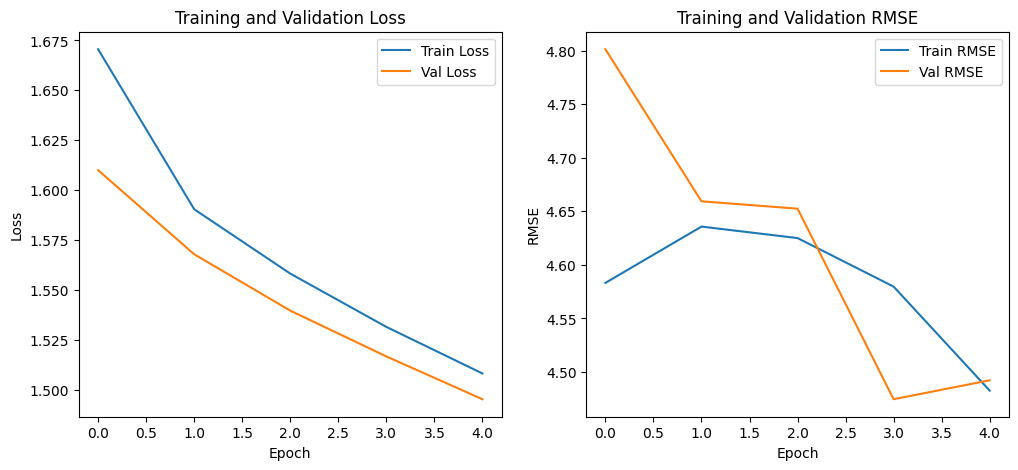

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_rmses, label="Train RMSE")
plt.plot(val_rmses, label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training and Validation RMSE")
plt.legend()
plt.show()

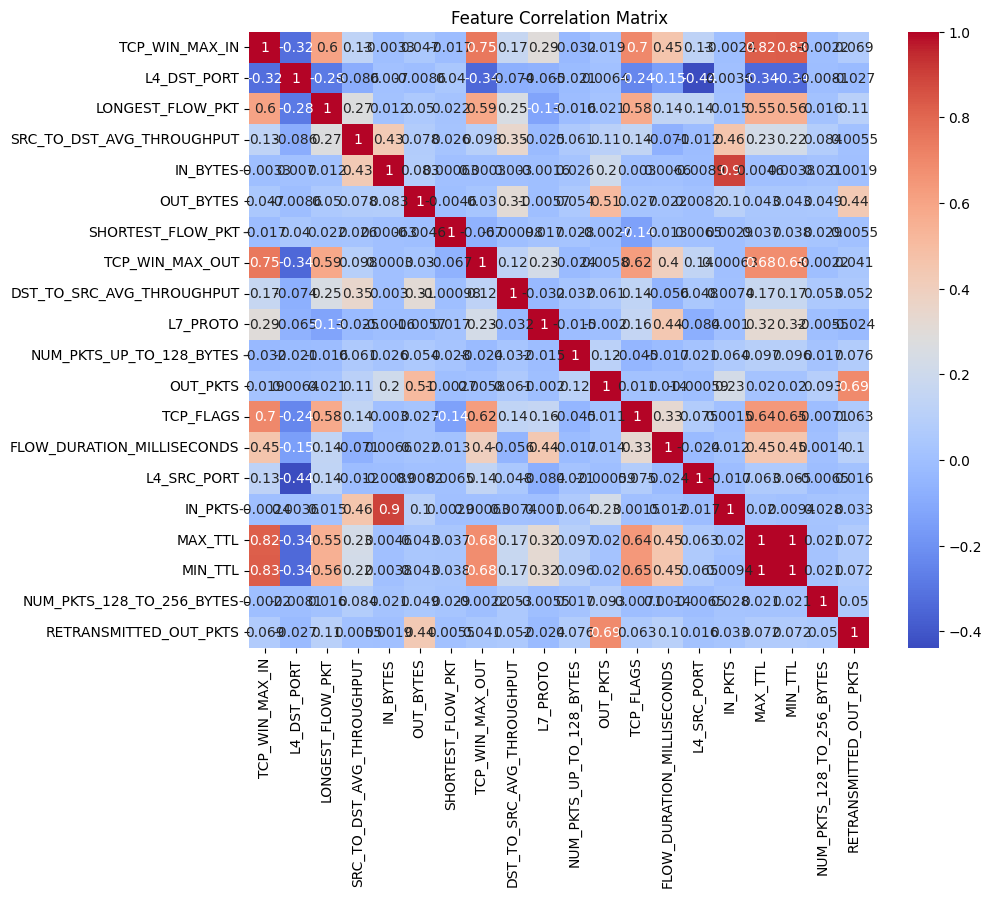

TCP_WIN_MAX_IN vs L4_DST_PORT: r=-0.325, p=0.000e+00, z=-0.337
TCP_WIN_MAX_IN vs LONGEST_FLOW_PKT: r=0.601, p=0.000e+00, z=0.695
TCP_WIN_MAX_IN vs SRC_TO_DST_AVG_THROUGHPUT: r=0.131, p=0.000e+00, z=0.132
TCP_WIN_MAX_IN vs IN_BYTES: r=-0.003, p=3.040e-01, z=-0.003
TCP_WIN_MAX_IN vs OUT_BYTES: r=0.047, p=5.071e-49, z=0.047
TCP_WIN_MAX_IN vs SHORTEST_FLOW_PKT: r=-0.017, p=8.908e-08, z=-0.017
TCP_WIN_MAX_IN vs TCP_WIN_MAX_OUT: r=0.751, p=0.000e+00, z=0.974
TCP_WIN_MAX_IN vs DST_TO_SRC_AVG_THROUGHPUT: r=0.166, p=0.000e+00, z=0.167
TCP_WIN_MAX_IN vs L7_PROTO: r=0.294, p=0.000e+00, z=0.303
TCP_WIN_MAX_IN vs NUM_PKTS_UP_TO_128_BYTES: r=-0.032, p=2.176e-24, z=-0.032
TCP_WIN_MAX_IN vs OUT_PKTS: r=0.019, p=1.272e-09, z=0.019
TCP_WIN_MAX_IN vs TCP_FLAGS: r=0.697, p=0.000e+00, z=0.862
TCP_WIN_MAX_IN vs FLOW_DURATION_MILLISECONDS: r=0.455, p=0.000e+00, z=0.491
TCP_WIN_MAX_IN vs L4_SRC_PORT: r=0.129, p=0.000e+00, z=0.130
TCP_WIN_MAX_IN vs IN_PKTS: r=-0.002, p=4.490e-01, z=-0.002
TCP_WIN_MAX_IN vs MAX

In [ ]:
corr_matrix = X_top.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

features = X_top.columns
for i in range(len(features)):
    for j in range(i+1, len(features)):
        x = X_top[features[i]]
        y_f = X_top[features[j]]
        r, p = stats.pearsonr(x, y_f)
        z = 0.5 * np.log((1+r)/(1-r))
        print(f"{features[i]} vs {features[j]}: r={r:.3f}, p={p:.3e}, z={z:.3f}")


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_test.extend(yb.cpu().numpy())
        y_pred_test.extend(preds.argmax(dim=1).cpu().numpy())

print("\nTest Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_true_test, y_pred_test))


Test Accuracy: 0.48846666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.09      0.14      4565
           1       0.00      0.00      0.00        22
           2       0.67      0.65      0.66      2287
           3       0.11      0.18      0.13       245
           4       0.70      0.10      0.17       848
           5       0.00      0.00      0.00         7
           6       0.32      0.73      0.44      1306
           7       0.00      0.00      0.00         4
           8       0.54      0.94      0.69      3950
           9       0.46      0.36      0.41      1766

    accuracy                           0.49     15000
   macro avg       0.32      0.31      0.26     15000
weighted avg       0.49      0.49      0.42     15000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
num_clients = 3
unique_attacks = np.unique(y)
np.random.shuffle(unique_attacks)

# Split attack types among clients
client_attack_map = {
    0: unique_attacks[:len(unique_attacks)//3],
    1: unique_attacks[len(unique_attacks)//3: 2*len(unique_attacks)//3],
    2: unique_attacks[2*len(unique_attacks)//3:]
}

client_data = {}
for cid, attacks in client_attack_map.items():
    mask = np.isin(y, attacks)
    X_client = X[mask]
    y_client = y[mask]

    X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
        X_client, y_client, test_size=0.2, stratify=y_client, random_state=42
    )

    # Convert to torch tensors
    client_data[cid] = {
        "X_train": torch.tensor(X_train_c, dtype=torch.float32).to(device),
        "y_train": torch.tensor(y_train_c, dtype=torch.long).to(device),
        "X_val": torch.tensor(X_val_c, dtype=torch.float32).to(device),
        "y_val": torch.tensor(y_val_c, dtype=torch.long).to(device),
    }

print("Clients prepared with heterogeneous attacks.")


In [ ]:
class ClientNN(nn.Module):
    def __init__(self, input_dim=12, output_dim=len(np.unique(y))):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(24, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
